# HW3: The Centralized Curator Model

### Bhaven Patel
### 4/2/2019

I worked with Anthony Rentsch, Lipika Ramaswamy, and Karina Huang on this homework.

My code can be found on my [Github](https://github.com/bhavenp/cs208/blob/master/homework/HW3/HW3_Bhaven_Patel.ipynb).

## Problem 1: Tails, Trimming, and Winsorization


**(a)**<br>

$$
M(x)=\dfrac{1}{0.9n}\left(\sum_{P_0.05 \leq x_i \leq P_0.95} x_i\right) + Lap\left( \dfrac{D}{0.9n\epsilon} \right)
$$

This implementation of the Trimmed mean is $\epsilon$-DP if the trimming transformation $T$ on $x$ ($x$ is trimmed from its 5th to its 95th percentile) is c-Lipschitz with $c=1$ and the mechanism $M$ is $\epsilon$-DP.

First, we can show that the trimming transformation $T$ on $x$ is c-Lipschitz with $c=1$:<br>
Begin with $x$ and $x'$, which hold $n$=20 values each in the range [0,...,D]
$$
x = [x_1, ..., x_{20}]\\
x' = [x_2, ..., x_{21}]\\
$$

The trimming transformation $T$ applied to $x$ and $x'$ would result in
$$
T(x) = [x_2, ..., x_{19}]\\
T(x') = [x_3, ..., x_{20}]\\
$$

$T(x)$ is $c$-Lipschitz if $\forall x,x' \;\; d(T(x), T(x')) \leq c\cdot d(x, x')$, where $d(x, x')$ denotes the distance between datasets $x$ and $x'$ defined by the number of rows you would need to change in $x'$ to make it the same as $x$. In this case, $d(x, x') = 1$ and $d(T(x), T(x')) = 1$, so $c=1$. Thus, $T(x)$ is $c$-Lipschitz with $c=1$. This would hold for any value of $n$.

A mechanism $M$ is $\epsilon$-DP when adding Laplace noise sampled from $Lap\left(\dfrac{GS}{\epsilon}\right)$, where $GS$ is the global sensitivity. In our case, the $GS = \dfrac{D}{0.9n}$ and we are adding $Lap\left(\dfrac{D}{0.9n\epsilon}\right)$ noise, so our mechanism is $\epsilon$-DP. From the lemma in class, since $M$ is $\epsilon$-DP and $T$ is $1$-Lipschitz, then $M\circ T$ is $1 \cdot \epsilon$-DP. Thus, this Trimmed mean algorithm is $\epsilon$-DP.


The code for the implementation is below.

In [1]:
rm(list=ls())		# Remove any objects in memory

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

In [2]:
# Generate a dataset of size
#
# max_value- maximum value any element in the dataset should take on
# size- number of elements to include in dataset
# 
# returns a differentially private mean release from the trimmed data

create_dataset = function(max_value, size){
    return(sample(0:max_value, size = size, replace = TRUE));
}

In [3]:
# Trimmed mean function for releasing a DP mean from data trimmed to its 5% to 95% intervals
#
# x- numeric vector of values
# max_value- maximum value any element in 'x' may take
# epsilon- privacy loss parameter
# 
# returns a differentially private mean release from the trimmed data

trimmed_mean = function(x, max_value, epsilon){
    n <- length(x); #get number of elements in x
    #get 5% and 95% cutoff values
    cutoffs <- quantile(x, probs = c(0.05, 0.95) )
    lower = cutoffs[1];
    upper = cutoffs[2];
    x.trimmed <- x[x >= lower & x <= upper]; #trim x
    
    sensitivity <- max_value/ (0.9*n);
    scale <- sensitivity / epsilon; #scale for Laplace noise

    sensitiveValue <- mean(x.trimmed)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

    return(list(release=DPrelease, true=sensitiveValue));
}

In [4]:
max_value = 10;
size = 20;

test <- create_dataset(max_value, size);
print(test)

trimmed_mean(test, max_value = max_value, epsilon = 0.4)

 [1]  1  7  3  7  9  5  9  5  7  9  3  4  4  1  2  4  8  6 10  8


$release
[1] 6.440918

$true
[1] 5.368421

<hr>

**(b)**<br>

<hr>

**(c)**<br>

## Need to describe implementation of percentile release

In [8]:
# percentile mean function for releasing a DP percentile from data 
#
# x- numeric vector of values
# tperc- percentile for which value from x should be chosen
# epsilon- privacy loss parameter
# 
# returns a differentially private percentile release from the data
percentileRelease <- function(x, tperc, lower, upper, nbins=0, epsilon){
	n <- length(x);
    xSorted <- sort(x, decreasing = FALSE);
	if(nbins==0){
		bins <- floor(lower):ceiling(upper);    # For integers, this is just lower:upper
        nbins <- length(bins);
    }
    else{
        #get vector of bin values
        bins <- seq(from=xSorted[1], to=xSorted[n], by=nbins);
    }
# 	x.clipped <- clip(x, lower, upper)
    sensitiveValue <- quantile(x, probs = c(percentile)); #get the true value at the desired percentile 

	utilities <- rep(NA, nbins); #create vector to hold utility score for each bin
	for(i in 1:length(utilities)){ #calculate the utility of each bin
        
		cntBelow <- sum(x.clipped<=bins[i]);
        cntAbove <- sum(x.clipped>=bins[i]);
        diff = t/(1-t) - cntBelow/cntAbove; #get difference between the true ratio of percentiles
        utilities[i] <- 1 - abs(diff);   
	}
    #calculate the actual probabilities for each bin
	likelihoods <- exp(epsilon * utilities / 2);
	probabilities <- likelihoods/sum(likelihoods);
    
    flag <- runif(n=1, min=0, max=1) < cumsum(probabilities) # See also rmultinom()
    DPrelease <- min(bins[flag]) 

    return(list(release=DPrelease, true=sensitiveValue))
}


<hr>

**(d)**<br>

<hr>

## Problem 2: Composition

In [ ]:
## PARAMETERS
delta = 10**(-9);
globalEps = 1;

kVals <- seq(from=1, to=1000, by=2); #get sequence of values for k

results <- matrix( rep(NA,length(kVals)*3), nrow=length(kVals), ncol=4);

for(i in 1:length(kVals)){
    k = kVals[i];
    #calculate standard deviation for basic epsilon
    epsBasic = globalEps / k;
    stdBasic = sqrt(2) / epsBasic;
    #calculate standard deviation for basic epsilon
    epsAdv = globalEps / sqrt(2*k*log(1/delta));
    stdAdv = sqrt(2) / epsAdv;
    
    #calculate standard deviation for 
    
    results[i, ] <- c(k, stdBasic, stdAdv, 0);
}

In [15]:
james_update_packages <- function(packageList){
	availableRepos <- getCRANmirrors()
	flag <- availableRepos$Country=="USA" & grepl("https",availableRepos$URL,)
	useRepos <- sample(availableRepos$URL[flag],1)

	## install missing packages, and update if newer version available
	for(i in 1:length(packageList)){
		if (!require(packageList[i],character.only = TRUE)){
    		install.packages(packageList[i], repos=useRepos)
   		}
	}

	update.packages(ask = FALSE, dependencies = c('Suggests'), oldPkgs=packageList, repos=useRepos)
}

packagelist <- c("devtools", "jsonlite", "openssl")
james_update_packages(packagelist)

Loading required package: devtools
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘devtools’”also installing the dependencies ‘desc’, ‘xopen’, ‘git2r’, ‘pkgbuild’, ‘pkgload’, ‘rcmdcheck’, ‘remotes’




  There are binary versions available but the source versions are later:
         binary source needs_compilation
git2r    0.25.1 0.25.2              TRUE
pkgbuild  1.0.2  1.0.3             FALSE
devtools 1.13.6  2.0.1             FALSE


The downloaded binary packages are in
	/var/folders/xq/l7fqjmss7pl_8cy28n_fz7680000gp/T//RtmpCMQ6GZ/downloaded_packages


installing the source packages ‘git2r’, ‘pkgbuild’, ‘devtools’

Warning message in install.packages(packageList[i], repos = useRepos):
“installation of package ‘pkgbuild’ had non-zero exit status”Warning message in install.packages(packageList[i], repos = useRepos):
“installation of package ‘devtools’ had non-zero exit status”Loading required package: jsonlite
Warning message:
“package ‘jsonlite’ was built under R version 3.4.4”Loading required package: openssl
Warning message:
“package ‘openssl’ was built under R version 3.4.4”Error: package or namespace load failed for ‘openssl’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 there is no package called ‘askpass’
also installing the dependencies ‘sys’, ‘askpass’




  There is a binary version available but the source version is later:
        binary source needs_compilation
openssl  1.2.2    1.3              TRUE


The downloaded binary packages are in
	/var/folders/xq/l7fqjmss7pl_8cy28n_fz7680000gp/T//RtmpCMQ6GZ/downloaded_packages


installing the source package ‘openssl’

Warning message in install.packages(packageList[i], repos = useRepos):
“installation of package ‘openssl’ had non-zero exit status”


  There is a binary version available but the source version is later:
        binary source needs_compilation
openssl  1.2.2    1.3              TRUE



installing the source package ‘openssl’

Warning message in install.packages(update[instlib == l, "Package"], l, repos = repos, :
“installation of package ‘openssl’ had non-zero exit status”

In [14]:
devtools::install_github("privacytoolsproject/PSI-Library", ref="develop") 
library("PSIlence")

ERROR: Error in loadNamespace(name): there is no package called ‘devtools’


In [13]:
library(PSIlence)
k <- 3;
init <- rep(c(1/k, 0), k )
params <- matrix(init, nrow=k, ncol=2, byrow=TRUE)
inverse <- PSIlence:::update_parameters(params=params, hold=0, eps=globalEps, del=delta)
print(inverse)

ERROR: Error in get(name, envir = asNamespace(pkg), inherits = FALSE): object 'update_parameters' not found


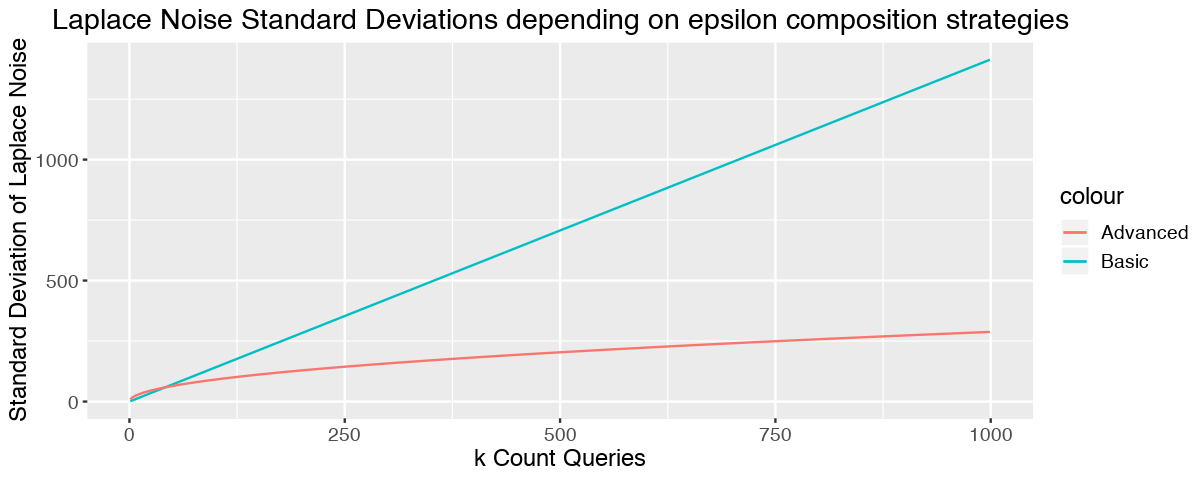

In [6]:
library(ggplot2)
library(grid)

final_results <- as.data.frame(results);
colnames(final_results) <- c("k", "Std_Basic_Comp", "Std_Adv_Comp", "Std_Opt_Comp");
f_size = 16;
fifty = 0.5;
# Plot average RMSE of reconstruction against noise input
p_rmse <- ggplot(data = final_results) + geom_line(aes(x=final_results$k, y=final_results$Std_Basic_Comp, color="Basic")) + geom_line(aes(x=final_results$k, y=final_results$Std_Adv_Comp, color="Advanced")); 
p_rmse <- p_rmse + labs(title="Laplace Noise Standard Deviations depending on epsilon composition strategies", x="k Count Queries", y = "Standard Deviation of Laplace Noise") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));
options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p_rmse #show plot